## EDA of my Dataset

Dataset loaded. Shape: (1199883, 24)

Columns: ['id', 'title', 'vote_average', 'vote_count', 'status', 'release_date', 'revenue', 'runtime', 'adult', 'backdrop_path', 'budget', 'homepage', 'imdb_id', 'original_language', 'original_title', 'overview', 'popularity', 'poster_path', 'tagline', 'genres', 'production_companies', 'production_countries', 'spoken_languages', 'keywords']

Missing Values:
id                            0
title                        13
vote_average                  0
vote_count                    0
status                        0
release_date             214298
revenue                       0
runtime                       0
adult                         0
backdrop_path            886150
budget                        0
homepage                1073623
imdb_id                  582342
original_language             0
original_title               13
overview                 251675
popularity                    0
poster_path              390604
tagline                 10

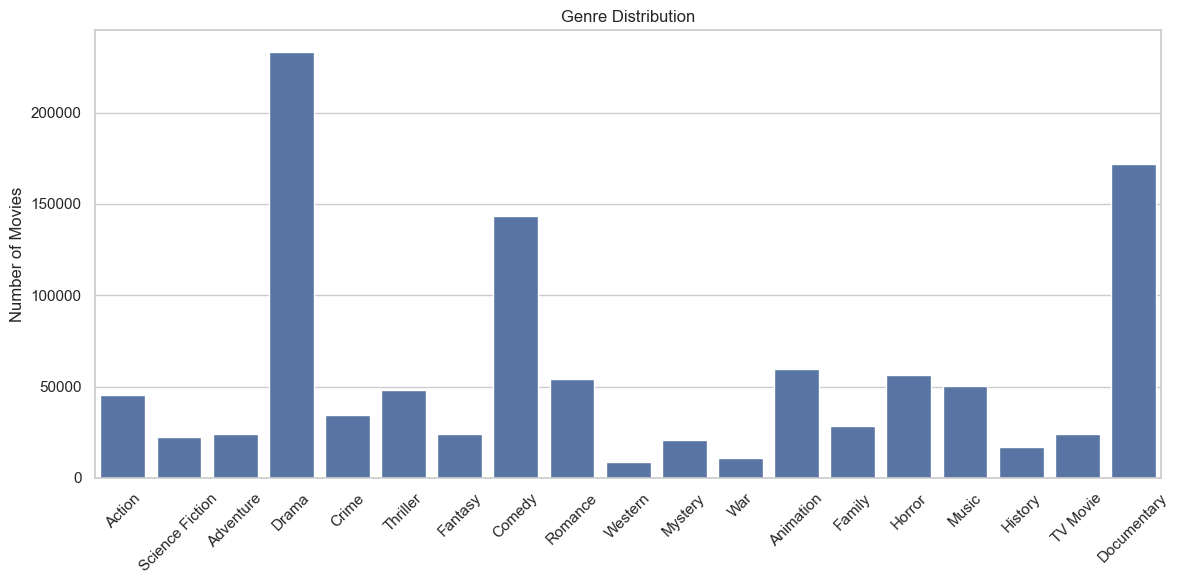

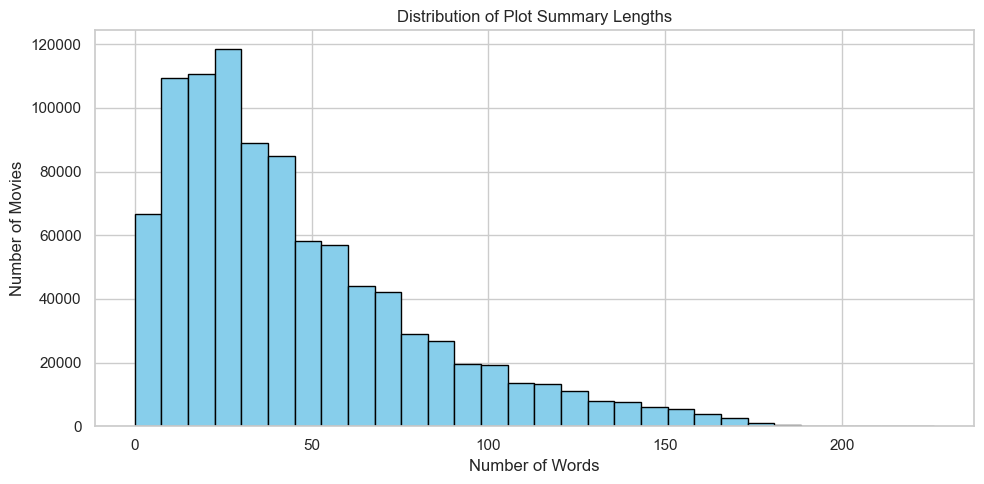

Average plot length (words): 45.61

Unique Movie IDs: 1199005
Movies with Poster Paths: 809279

Summary Stats:
- Total movies: 1199883
- Average genres per movie: 0.90
- Average overview length: 45.61 words
- Unique genres: 19
- Movies with posters: 809279


In [ ]:
# 01_EDA_TMDB_v11_Clean.ipynb

# Step 1: Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 5)

# Step 2: Load Dataset
df = pd.read_csv("data/TMDB_movie_dataset_v11.csv")
print("Dataset loaded. Shape:", df.shape)
df.head()

# Step 3: Check Columns & Missing Data
print("\nColumns:", df.columns.tolist())
print("\nMissing Values:")
print(df.isnull().sum())

# Step 4: Parse and Analyze Genres
df['genre_list'] = df['genres'].fillna("").apply(lambda x: [g.strip() for g in x.split(',') if g.strip()])
all_genres = [genre for sublist in df['genre_list'] for genre in sublist]
genre_counts = Counter(all_genres)

plt.figure(figsize=(12, 6))
sns.barplot(x=list(genre_counts.keys()), y=list(genre_counts.values()))
plt.title("Genre Distribution")
plt.xticks(rotation=45)
plt.ylabel("Number of Movies")
plt.tight_layout()
plt.show()

# Step 5: Plot Length of Plot Summaries
df['overview_length'] = df['overview'].dropna().apply(lambda x: len(x.split()))

plt.hist(df['overview_length'], bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution of Plot Summary Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Number of Movies")
plt.tight_layout()
plt.show()

print("Average plot length (words):", round(df['overview_length'].mean(), 2))

# Step 6: ID and Poster Availability
print("\nUnique Movie IDs:", df['id'].nunique())
print("Movies with Poster Paths:", df['poster_path'].notnull().sum())

# Final Summary
print("\nSummary Stats:")
print(f"- Total movies: {len(df)}")
print(f"- Average genres per movie: {df['genre_list'].apply(len).mean():.2f}")
print(f"- Average overview length: {df['overview_length'].mean():.2f} words")
print(f"- Unique genres: {len(genre_counts)}")
print(f"- Movies with posters: {df['poster_path'].notnull().sum()}")


## Cleaning the dataset based on EDA

#### Processing Genres for Multi-Label Classification
#### Here genre column is a string like "Action, Adventure, Sci-Fi". We'll need to convert that into a list
#### So, doing One-hot encode using MultiLabelBinarizer

In [1]:
from sklearn.preprocessing import MultiLabelBinarizer
import pandas as pd

# Load original dataset
df = pd.read_csv("data/TMDB_movie_dataset_v11.csv")

# Step 1: Filter rows with valid genres, overview, and poster
df_clean = df[
    df['genres'].notnull() & 
    df['overview'].notnull() & 
    df['poster_path'].notnull() &
    df['keywords'].notnull() ]

# Step 2: Convert genres to list
df_clean['genre_list'] = df_clean['genres'].apply(lambda x: [g.strip() for g in x.split(',') if g.strip()])

# Step 3: One-hot encode genres
mlb = MultiLabelBinarizer()
genre_matrix = pd.DataFrame(mlb.fit_transform(df_clean['genre_list']), columns=mlb.classes_)

# Step 4: Clean overview text (strip, remove newlines)
df_clean['overview'] = df_clean['overview'].str.strip().str.replace('\n', ' ').str.replace('\r', ' ')

# Step 5: Drop unnecessary columns — only keep what's needed
columns_to_keep = ['id', 'title', 'overview', 'poster_path', 'genre_list']
df_clean = df_clean[columns_to_keep]

# Step 6: Add genre one-hot columns
df_clean = pd.concat([df_clean.reset_index(drop=True), genre_matrix], axis=1)

# Step 7: Remove duplicate movie IDs (if any) and reset index
df_clean.drop_duplicates(subset='id', inplace=True)
df_clean.reset_index(drop=True, inplace=True)

# Step 8: check genre label distribution
print("Label distribution (top 10):")
print(df_clean[mlb.classes_].sum().sort_values(ascending=False).head(10))

# Step 9: Save the final cleaned dataset
df_clean.to_csv("data/dataset_cleaned.csv", index=False)
print("Final cleaned dataset saved as: data/dataset_cleaned.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'data/TMDB_movie_dataset_v11.csv'

## Check the new dataset

In [ ]:
df_check = pd.read_csv("data/dataset_cleaned.csv")
print("Loaded shape:", df_check.shape)
df_check.head()

## Now EDA on my cleaned_dataset
### Note: figure out multi and single label movies 

In [ ]:
# EDA_Cleaned_Dataset.ipynb

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 5)

# Step 1: Load the cleaned dataset
df = pd.read_csv("data/dataset_cleaned.csv")
print("Dataset shape:", df.shape)
df.head()


In [ ]:
# step 2: Genre Distribution
# Identify genre columns (everything after 'poster_path' and 'genre_list')
genre_columns = df.columns[5:]

# Count number of samples per genre
genre_counts = df[genre_columns].sum().sort_values(ascending=False)

# Plot genre distribution
plt.figure(figsize=(12, 6))
sns.barplot(x=genre_counts.index, y=genre_counts.values)
plt.title("Genre Distribution (Cleaned Dataset)")
plt.ylabel("Number of Movies")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# Step3: Plot length distribution 
df['overview_length'] = df['overview'].apply(lambda x: len(str(x).split()))

plt.hist(df['overview_length'], bins=30, color='skyblue', edgecolor='black')
plt.title("Plot Summary Length Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Number of Movies")
plt.tight_layout()
plt.show()

print("Average plot summary length:", df['overview_length'].mean())


In [ ]:
# step 4: Genre count per movie
import seaborn as sns
import matplotlib.pyplot as plt
# Make sure you’re only summing the genre columns (not metadata)
genre_columns = [
    'Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama',
    'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Mystery', 'Romance',
    'Science Fiction', 'TV Movie', 'Thriller', 'War', 'Western'
]

df['num_genres'] = df[genre_columns].sum(axis=1)

# Countplot of genres per movie
sns.countplot(x='num_genres', data=df, hue='num_genres', palette='pastel', legend=False)
plt.title("Number of Genres per Movie")
plt.xlabel("Genres per Movie")
plt.ylabel("Movie Count")
plt.xlim(0, 6)  # Only show 0–5 genres
plt.tight_layout()
plt.show()


In [ ]:
# Checking for any Issues
print("\nMissing values:")
print(df.isnull().sum())

print("\nBasic stats:")
print(f"Total samples: {len(df)}")
print(f"Average genres per movie: {df['num_genres'].mean():.2f}")
print(f"Average plot length: {df['overview_length'].mean():.2f} words")
print(f"Total unique genres: {len(genre_columns)}")


In [ ]:
## Further cleaning the missing values
# Drop rows with missing title or overview
df = df.dropna(subset=['title', 'overview']).reset_index(drop=True)
print("New shape after dropping missing titles/overviews:", df.shape)
print("\nMissing values:")
print(df.isnull().sum())
# Checking again for any Issues
print("\nBasic stats:")
print(f"Total samples: {len(df)}")
print(f"Average genres per movie: {df['num_genres'].mean():.2f}")
print(f"Average plot length: {df['overview_length'].mean():.2f} words")
print(f"Total unique genres: {len(genre_columns)}")

## Splitting the data in to train, val, test (80/10/10)

In [ ]:
import pandas as pd
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

# Load dataset
df = pd.read_csv("data/dataset_cleaned.csv")

# Input features and labels
X = df[['id', 'title', 'overview', 'poster_path']]
genre_columns = df.columns[5:]
Y = df[genre_columns].values

# --- First Split: 80% Train, 20% Temp ---
mskf = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_idx, temp_idx = next(mskf.split(X, Y))

X_train, Y_train = X.iloc[train_idx], Y[train_idx]
X_temp, Y_temp = X.iloc[temp_idx], Y[temp_idx]

# --- Second Split: 50/50 on Temp → 10% Val, 10% Test ---
mskf2 = MultilabelStratifiedKFold(n_splits=2, shuffle=True, random_state=42)
val_idx, test_idx = next(mskf2.split(X_temp, Y_temp))

X_val, Y_val = X_temp.iloc[val_idx], Y_temp[val_idx]
X_test, Y_test = X_temp.iloc[test_idx], Y_temp[test_idx]

# --- Reconstruct dataframes with labels ---
df_train = pd.concat([X_train.reset_index(drop=True), pd.DataFrame(Y_train, columns=genre_columns)], axis=1)
df_val   = pd.concat([X_val.reset_index(drop=True), pd.DataFrame(Y_val, columns=genre_columns)], axis=1)
df_test  = pd.concat([X_test.reset_index(drop=True), pd.DataFrame(Y_test, columns=genre_columns)], axis=1)

# --- Save splits ---
df_train.to_csv("data/train.csv", index=False)
df_val.to_csv("data/val.csv", index=False)
df_test.to_csv("data/test.csv", index=False)

print("Data split complete and saved.")
print(f"Train: {df_train.shape}, Val: {df_val.shape}, Test: {df_test.shape}")


In [ ]:
# Visualising the splits !
import pandas as pd
import matplotlib.pyplot as plt

# Load your splits
df_train = pd.read_csv("data/train.csv")
df_val   = pd.read_csv("data/val.csv")
df_test  = pd.read_csv("data/test.csv")

# Identify genre columns
genre_columns = df_train.columns[5:]  # After: id, title, overview, poster_path, genre_list

# Count genres in each split
train_counts = df_train[genre_columns].sum()
val_counts   = df_val[genre_columns].sum()
test_counts  = df_test[genre_columns].sum()

# Combine into one DataFrame for plotting
genre_df = pd.DataFrame({
    'Train': train_counts,
    'Validation': val_counts,
    'Test': test_counts
})

# Normalize (optional: view % share instead of absolute)
genre_df_normalized = genre_df.divide(genre_df.sum(axis=0), axis=1)

# Plot
genre_df_normalized.plot(kind='bar', figsize=(12, 6))
plt.title("Normalized Genre Distribution Across Train / Val / Test Splits")
plt.ylabel("Proportion of Samples")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Building baseline model for text based genre prediction

In [ ]:
# -------------------------------------
# TF-IDF + Logistic Regression Baseline
# -------------------------------------

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report

# -----------------------------
# Step 1: Load and Clean Data
# -----------------------------
train_df = pd.read_csv("data/train.csv")
val_df = pd.read_csv("data/val.csv")
test_df = pd.read_csv("data/test.csv")

# Drop rows with missing overviews
train_df = train_df.dropna(subset=['overview']).reset_index(drop=True)
val_df = val_df.dropna(subset=['overview']).reset_index(drop=True)
test_df = test_df.dropna(subset=['overview']).reset_index(drop=True)

# -----------------------------
# Step 2: Define X (input) and Y (multi-label genres)
# -----------------------------
X_train = train_df['overview']
X_val = val_df['overview']
X_test = test_df['overview']

# Assume genre columns start from 5th index onward
genre_columns = train_df.columns[5:]
Y_train = train_df[genre_columns]
Y_val = val_df[genre_columns]
Y_test = test_df[genre_columns]

# -----------------------------
# Step 3: Build TF-IDF + Logistic Regression Pipeline
# -----------------------------
model = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, stop_words='english')),
    ('clf', OneVsRestClassifier(LogisticRegression(solver='liblinear')))
])

# -----------------------------
# Step 4: Train the Model
# -----------------------------
print(" Training model...")
model.fit(X_train, Y_train)

# -----------------------------
# Step 5: Evaluate on Validation Set
# -----------------------------
print("\n Evaluating on Validation Set...")
Y_pred_val = model.predict(X_val)

# Clean evaluation with zero_division set to 0
report = classification_report(
    Y_val, Y_pred_val, target_names=genre_columns, zero_division=0
)
print(report)

# -----------------------------
# Step 6: (Optional) Evaluate on Test Set
# -----------------------------
print("\n Evaluating on Test Set...")
Y_pred_test = model.predict(X_test)
print(classification_report(Y_test, Y_pred_test, target_names=genre_columns, zero_division=0))


### Observaions:-
Micro F1 = 0.50	Overall, your model is decent at predicting popular genres across all samples.
Macro F1 = 0.35	It struggles with less common genres (imbalanced classes).
Samples F1 = 0.46	Your model sometimes misses part of a movie's genre set (partial match).
Best genres: Documentary, Drama, Music, Western	Your model identifies consistent, well-defined genres well.
Worst genres: Fantasy, TV Movie, Mystery, Adventure	These may have vague, overlapping, or less distinct plot keywords.
## So, planning to proceed for Deep Learning models like ( LSTM / BERT)
LSTM or BERT models can learn:

“A quest for the ring…” = Fantasy

“A magical school for children…” = Adventure / Fantasy

These models are better at capturing nuance than TF-IDF.